# Home Credit Default Risk Prediction

## Exploratory Data Analysis (EDA)

In [66]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Loading data

In [67]:
data = pd.read_csv("data/final_non_null_data_train.csv")

In [68]:
data=data.drop(['Unnamed: 0'],axis=1)

In [69]:
data['DAYS_BIRTH']= data['DAYS_BIRTH']/-365

## Visualization -  Who accompained client when applying the loan 

Text(0.5,1,'Who accompanied client when applying for the  application in % ')

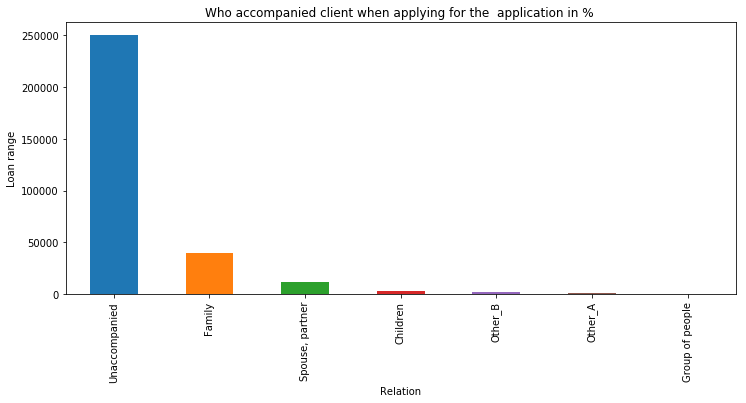

In [19]:
plt.figure(figsize=(12,5))
data['NAME_TYPE_SUITE'].value_counts(sort=True).plot.bar()
plt.xlabel('Relation')
plt.ylabel('Loan range')
plt.title("Who accompanied client when applying for the  application in % ")

## Visualization - Distribution of Repayer vs Defaulter 

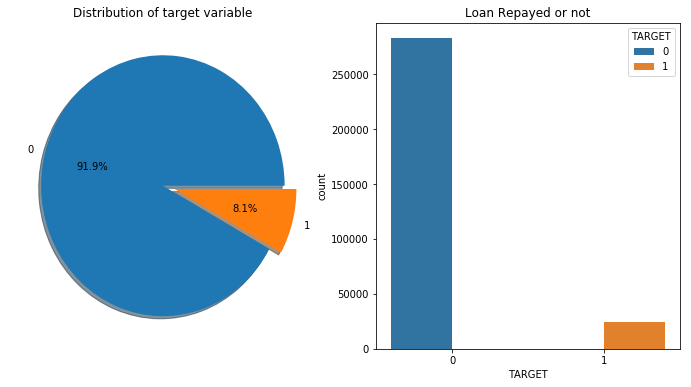

In [20]:
f,ax=plt.subplots(1,2,figsize=(12,6))
data.TARGET.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Distribution of target variable')
ax[0].set_ylabel('')
sns.countplot('TARGET',data=data,ax=ax[1],hue='TARGET')
ax[1].set_title('Loan Repayed or not')
plt.show()

## Visualization - Distribution of Family status for Repayers and Defaulters 

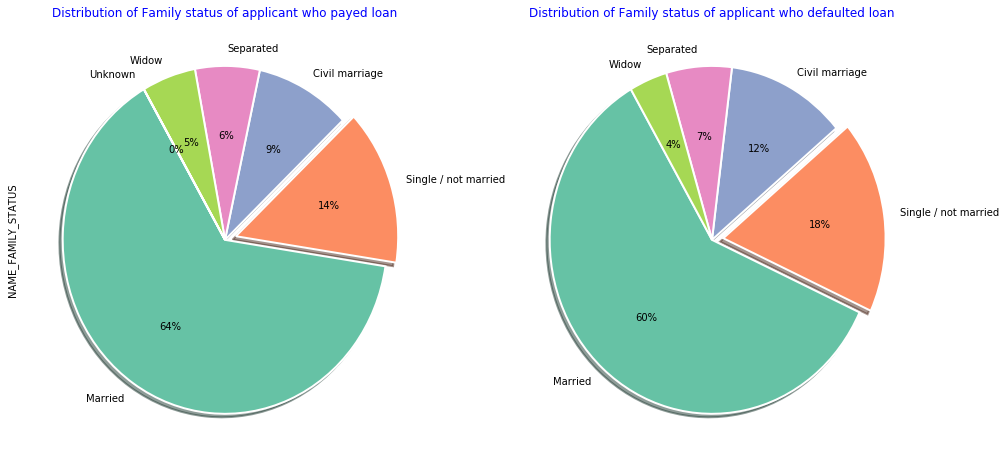

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(121)
data[data["TARGET"]==0]["NAME_FAMILY_STATUS"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                             startangle=120,colors = sns.color_palette("Set2",7),
                                              wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True,explode=[0,.07,0,0,0,0])

plt.title("Distribution of Family status of applicant who repayed loan",color="b")

plt.subplot(122)
data[data["TARGET"]==1]["NAME_FAMILY_STATUS"].value_counts().plot.pie(autopct = "%1.0f%%",
                                                    startangle=120,colors = sns.color_palette("Set2",7),
                                              wedgeprops={"linewidth":2,"edgecolor":"white"},shadow =True,explode=[0,.07,0,0,0])


plt.title("Distribution of Family status of applicant who defaulted loan",color="b")
plt.ylabel("")
plt.show()

## Visualization - Distribution of Family status for Repayers and Defaulters 

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

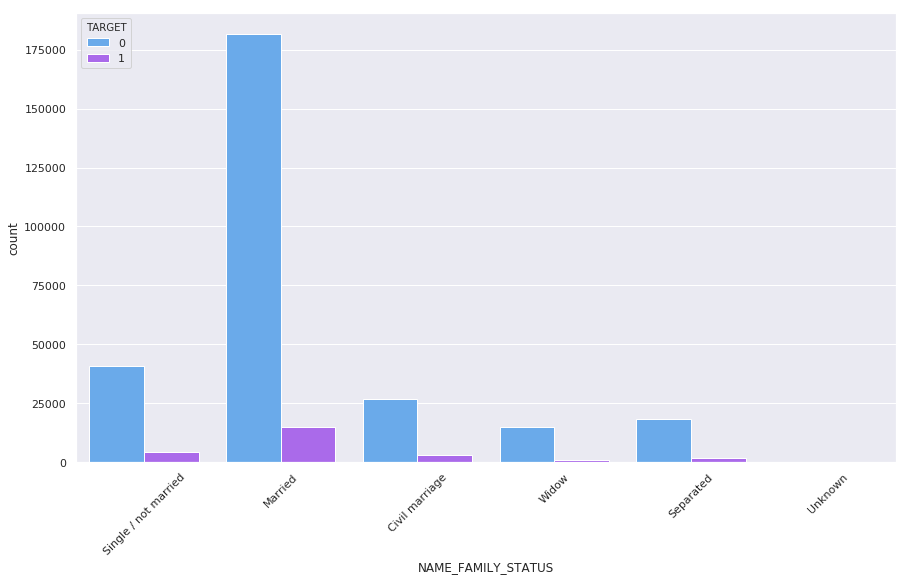

In [106]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.countplot(x="NAME_FAMILY_STATUS", hue="TARGET", data=data, palette='cool')
plt.xticks(rotation=45)

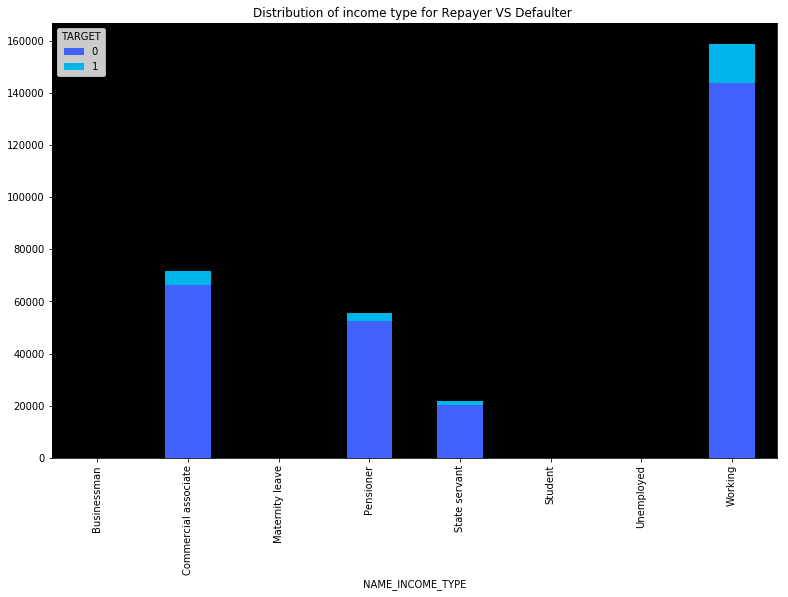

In [22]:
ax = pd.crosstab(data["NAME_INCOME_TYPE"],data["TARGET"]).plot(kind="bar",color=sns.color_palette("rainbow",7),
                                                                                                                     figsize=(13,8),stacked=True)
ax.set_facecolor("k")
ax.set_title("Distribution of income type for Repayer VS Defaulter ")
plt.show()

## Visualization - Scatter plot between credit amount and annuity amount 

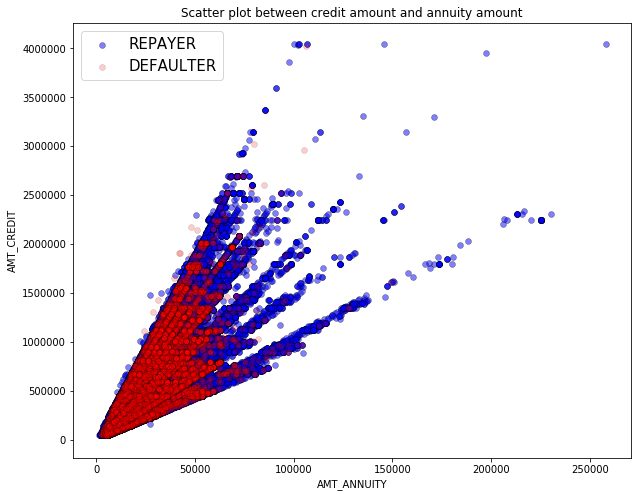

In [24]:
fig = plt.figure(figsize=(10,8))
plt.scatter(data[data["TARGET"]==0]['imputed_AMT_ANNUITY'],data[data["TARGET"]==0]['AMT_CREDIT'],s=35,
            color="b",alpha=.5,label="REPAYER",linewidth=.5,edgecolor="k")
plt.scatter(data[data["TARGET"]==1]['imputed_AMT_ANNUITY'],data[data["TARGET"]==1]['AMT_CREDIT'],s=35,
            color="r",alpha=.2,label="DEFAULTER",linewidth=.5,edgecolor="k")
plt.legend(loc="best",prop={"size":15})
plt.xlabel("AMT_ANNUITY")
plt.ylabel("AMT_CREDIT")
plt.title("Scatter plot between credit amount and annuity amount")
plt.show()

## Visualization - Average Earnings by different professions and education types 

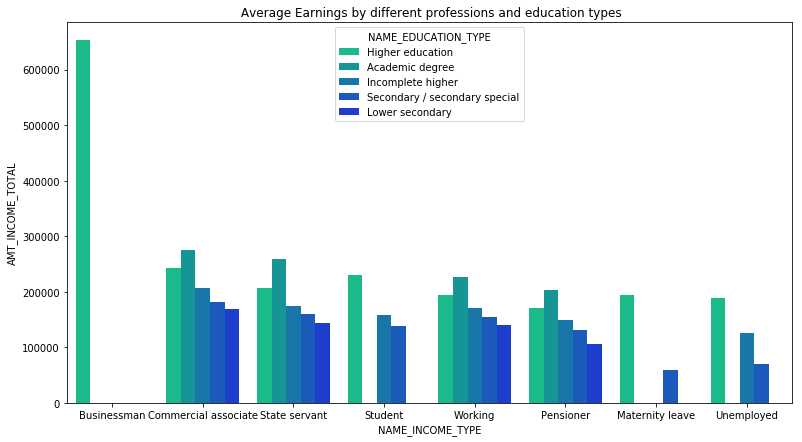

In [25]:
edu = data.groupby(['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE'])['AMT_INCOME_TOTAL'].mean().reset_index().sort_values(by='AMT_INCOME_TOTAL',ascending=False)
fig = plt.figure(figsize=(13,7))
ax = sns.barplot('NAME_INCOME_TYPE','AMT_INCOME_TOTAL',data=edu,hue='NAME_EDUCATION_TYPE',palette="winter_r")
#ax.set_facecolor("")
plt.title(" Average Earnings by different professions and education types")
plt.show()

## Visualization - Peak hours for week days

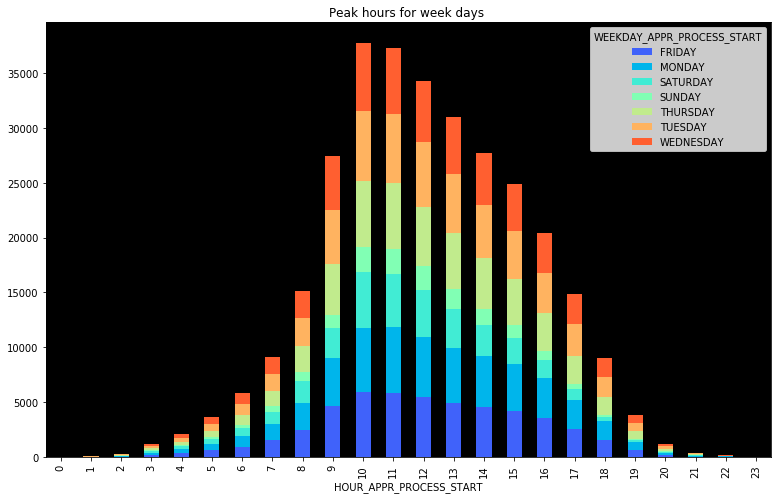

In [26]:
ax = pd.crosstab(data["HOUR_APPR_PROCESS_START"],data["WEEKDAY_APPR_PROCESS_START"]).plot(kind="bar",color=sns.color_palette("rainbow",7),
                                                                                                                     figsize=(13,8),stacked=True)
ax.set_facecolor("k")
ax.set_title("Peak hours for week days ")
plt.show()

## Correlation among features 

Text(0.5,1,'Correlation among features')

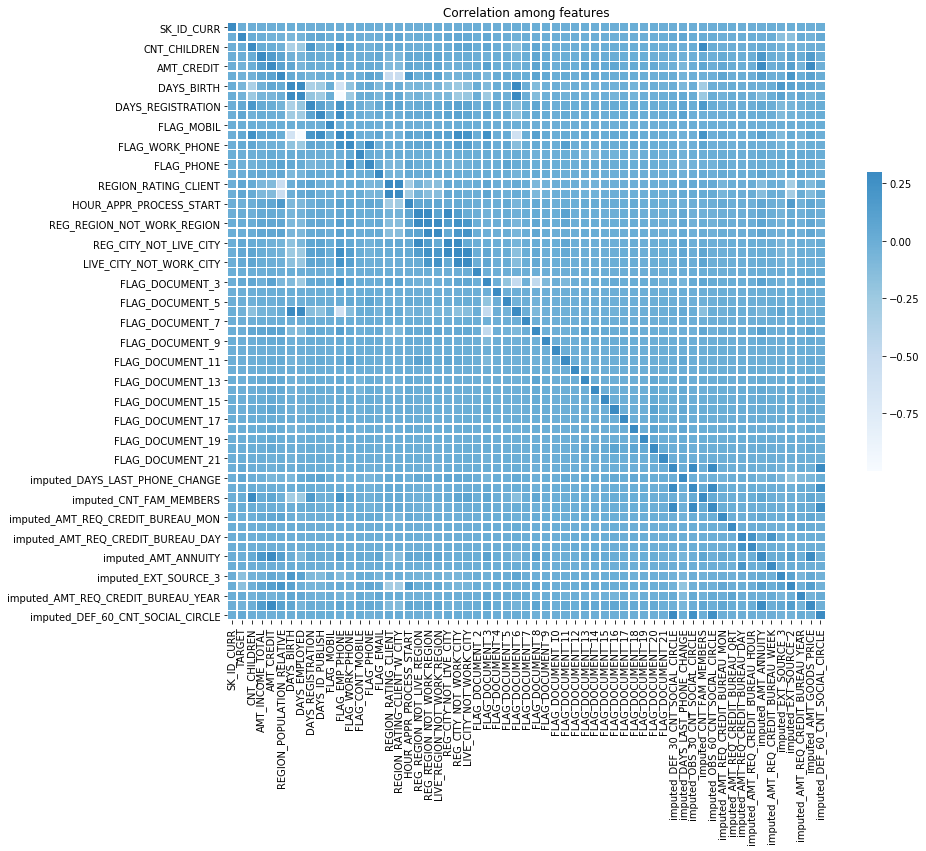

In [27]:
corr = data.corr()
f, ax = plt.subplots(figsize=(15, 11))
plot = sns.heatmap(corr, cmap='Blues', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Correlation among features")

## Most Correlation among features

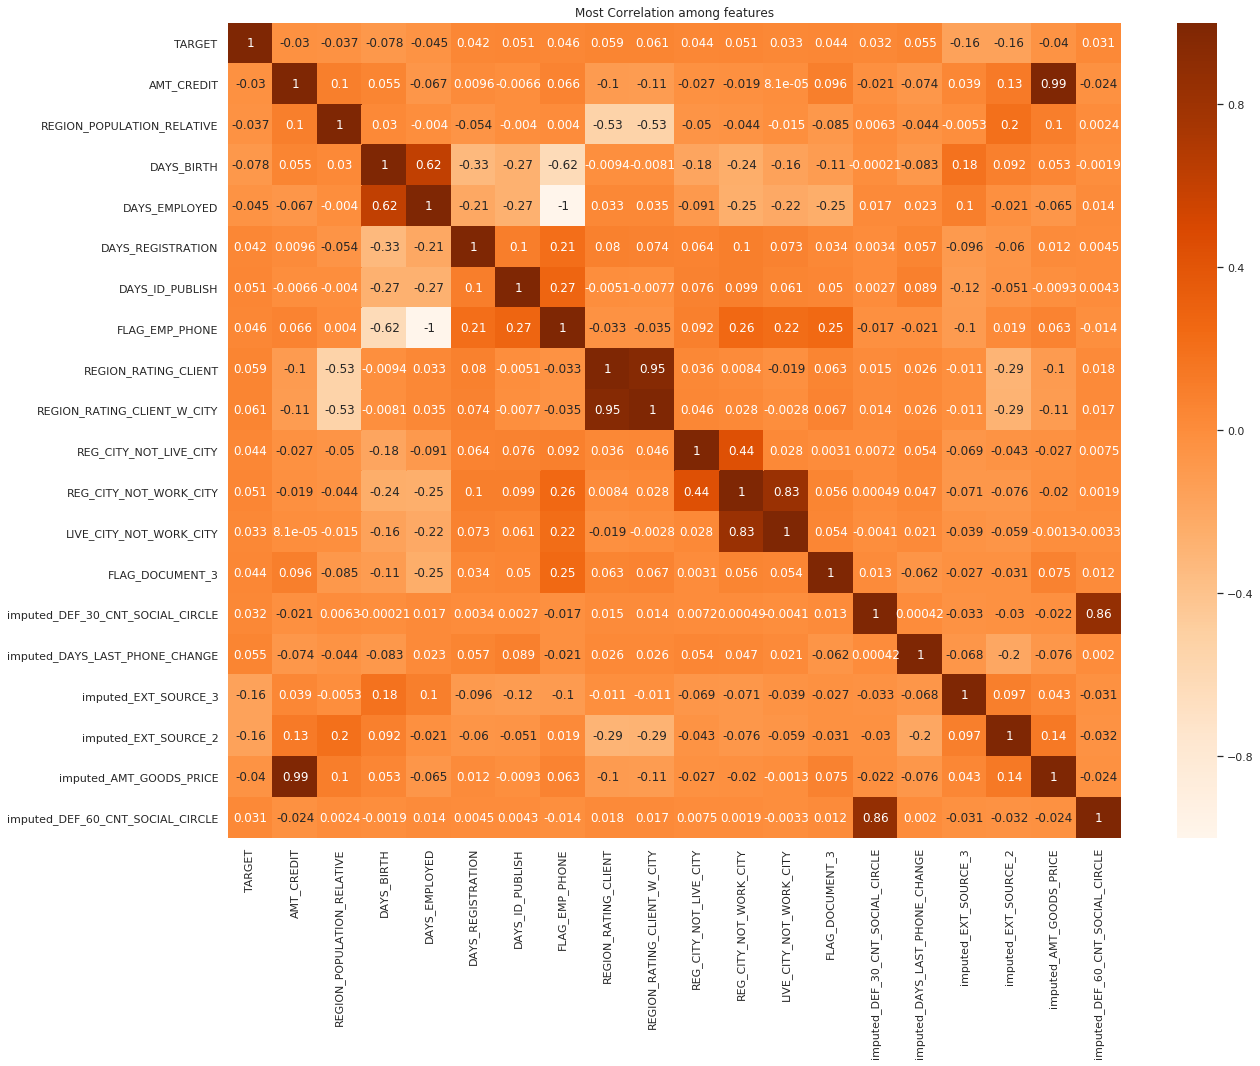

In [117]:
# most correlated features
corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat["TARGET"])>=0.03]
plt.figure(figsize=(20,15))
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap='Oranges').set_title("Most Correlation among features")

# Further processing 

In [28]:
from pyspark.sql import SparkSession

In [29]:
import lib.initShared  # custom library
import os

In [30]:
#Capture working directory
cwd = os.getcwd()

In [31]:
# Initialize environment to load custom libraries from shared path
lib.initShared.initializeSharedLib(cwd)

In [32]:
spark = SparkSession.builder.appName('HomeCredit').getOrCreate()

## 1. Importing Custom Libraries

In [58]:
from S3serializer_Lib.S3Serializer import S3Bucket
from Data_Cleaning_Lib.CleanLib import DataCleaningLib
from Encode_Lib import EncodeLib
from Model_Fit_Lib import Model_Fit
from Feature_Importance_Lib.Feature_Importance import Feature_Importance_Transformer

# 2. Connecting to remote cluster using S3Bucket library

In [59]:
s3=S3Bucket()
s3.connect(host = "18.212.194.194", username = "centos", key = './InternalPOC_Digital.pem')

Connecting to host  18.212.194.194
Connected


## 3. Getting data from remote cluster

In [60]:
s3.get_dir_remote('dataset','home_credit')

Getting data...
Getting File--> part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> _SUCCESS
['part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', '_SUCCESS']


## 4. Loading data

In [61]:
data=spark.read.parquet('./dataset')

## 6. Data Cleansing using Data_Cleaning library

##### Data_Cleaning library does:
1. Removes the highest null value column(30%)
2. Imputes the remaining null containing columns with frequent occuring value of the respective columns

In [62]:
cln = DataCleaningLib()

In [63]:
data=cln.cleaning(data)

1.Data Cleaning and Preprocessing
processing--> SK_ID_CURR
processing--> TARGET
processing--> NAME_CONTRACT_TYPE
processing--> CODE_GENDER
processing--> FLAG_OWN_CAR
processing--> FLAG_OWN_REALTY
processing--> CNT_CHILDREN
processing--> AMT_INCOME_TOTAL
processing--> AMT_CREDIT
processing--> AMT_ANNUITY
processing--> AMT_GOODS_PRICE
processing--> NAME_TYPE_SUITE
processing--> NAME_INCOME_TYPE
processing--> NAME_EDUCATION_TYPE
processing--> NAME_FAMILY_STATUS
processing--> NAME_HOUSING_TYPE
processing--> REGION_POPULATION_RELATIVE
processing--> DAYS_BIRTH
processing--> DAYS_EMPLOYED
processing--> DAYS_REGISTRATION
processing--> DAYS_ID_PUBLISH
processing--> OWN_CAR_AGE
processing--> FLAG_MOBIL
processing--> FLAG_EMP_PHONE
processing--> FLAG_WORK_PHONE
processing--> FLAG_CONT_MOBILE
processing--> FLAG_PHONE
processing--> FLAG_EMAIL
processing--> OCCUPATION_TYPE
processing--> CNT_FAM_MEMBERS
processing--> REGION_RATING_CLIENT
processing--> REGION_RATING_CLIENT_W_CITY
processing--> WEEKDAY

In [14]:
data_pandas=data.toPandas()
y=data_pandas['TARGET'].values
data_pandas.drop(['TARGET','SK_ID_CURR'],axis=1,inplace=True)
categorical_columns=set(data_pandas.columns)-set(data_pandas._get_numeric_data().columns)
numeric_columns=data_pandas._get_numeric_data().columns
X=data_pandas[list(numeric_columns)].values

## 7. Feature Selection Using Feature_Importance library

#### Feature_Importance library contains various feature selection algorithm(LightGBM, CatBoostClassifier, RandomForestClassifier) to select the best correlated features

In [15]:
fi = Feature_Importance_Transformer(data_pandas)

Plot Top 40 feature importances…


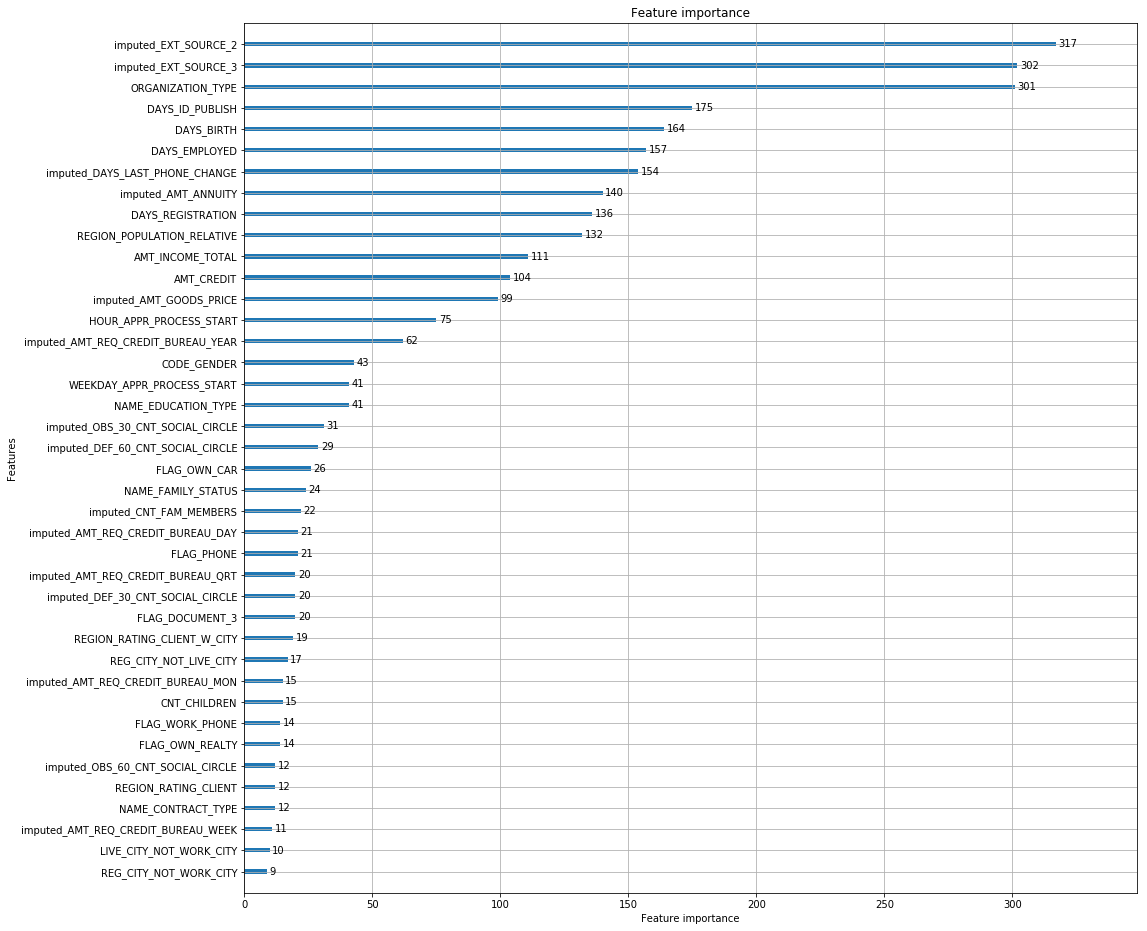

In [16]:
fi.feature_importance_lightGBM(y=y,categorical_columns=categorical_columns,n_features=40)

## 8. Label Encoding using EncodeLib library

##### EncodeLib library contains class for Label Encoding(LabelEncode) which encodes all the categorical columns in the dataframe and returns the string indexed dataframe

In [17]:
pp = EncodeLib.LabelEncode(outputCols=['TARGET'])

In [18]:
data = pp.transform(data)

ORGANIZATION_TYPE
FLAG_OWN_REALTY
NAME_CONTRACT_TYPE
WEEKDAY_APPR_PROCESS_START
NAME_FAMILY_STATUS
NAME_INCOME_TYPE
CODE_GENDER
FLAG_OWN_CAR
NAME_HOUSING_TYPE
NAME_TYPE_SUITE
NAME_EDUCATION_TYPE


## 9. One Hot Encoding using EncodeLib library

##### EncodeLib library contains class for One Hot Encoding(OHEncode) which encodes the string indexed columns in the dataframe and returns the encoded(vectors) dataframe\

In [19]:
ohe = EncodeLib.OHEncode()

In [20]:
data = ohe.transform(data)

# 10. Converting independant variables to vectors using EncodeLib library

##### VectorChange class in EncodeLib library converts all the independent variables into single column named 'features'(vector) which can be used for model building

In [21]:
vec = EncodeLib.VectorChange(outputCols=['TARGET'])

In [22]:
data = vec.transform(data)

## 11. Model Building using Model_Fit library

##### ModelFit class in Model_Fit library applies data on classification model and returns the predcition score
-------
##### Logistic Regression

In [23]:
model1 = Model_Fit.ModelFit(inputCol='LR')

In [24]:
log_reg_pred = model1.transform(data)

In [25]:
model1._evaluate_prediction()

0.7377170390898882


##### Random Forest Classifier

In [26]:
model2 = Model_Fit.ModelFit(inputCol='RF')

In [27]:
rand_forest_pred = model2.transform(data)

In [28]:
model2._evaluate_prediction()

0.7055222501556329


## 12. Model Saving / Loading and Prediction

In [29]:
#saving Model
log_reg_pred.save('log_reg.pkl')

In [30]:
from pyspark.ml.classification import LogisticRegressionModel

In [31]:
#loading Model
mm = LogisticRegressionModel.load('log_reg.pkl')

In [32]:
predicted=mm.transform(data)

In [33]:
predicted.select('prediction').show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



## 13. API Deployment

In [1]:
import lib.initShared  # custom library
import os

In [2]:
#Capture working directory
cwd = os.getcwd()

In [3]:
# Initialize environment to load custom libraries from shared path
lib.initShared.initializeSharedLib(cwd)

In [4]:
import apilib  # shared custom library

In [5]:
# Initialize parameters - swagger spec file, app Port
swaggerSpecFile = cwd+'/data/swagger_HomeCreditRisk.yaml'
appPort = 8000

In [6]:
# Swagger UI becomes available after running API on URL http://<serverUrl>:mappedPort/ui
# mappedPort is port mapped as per nginx configuration
# For port 8000, mappedPort is 9390, thus URL is http://34.198.60.96:9390/ui/

# Run API
apilib.api_run(swaggerSpecFile, appPort)

# To stop the API, interrupt the cell (using button provided) or shutdown notebook (using Notebook interface)

 * Running on http://0.0.0.0:8000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Jan/2019 06:40:10] "GET /ui/ HTTP/1.0" 200 -
127.0.0.1 - - [04/Jan/2019 06:40:11] "GET /swagger.json HTTP/1.0" 200 -
127.0.0.1 - - [04/Jan/2019 06:40:11] "GET /ui/images/favicon-32x32.png HTTP/1.0" 200 -
127.0.0.1 - - [04/Jan/2019 06:40:30] "POST /predictions HTTP/1.0" 200 -


# End-of-notebook